# Train syllable prediction model (without word boundaries, using softmax)

This notebook experiments with syllable prediction from phonetics only. Word boundaries are not known. Sanity check is built-in, i.e. by design there is exactly one vowel per syllable.

In [1]:
import regex as re

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
# Dataset loader
def load_dataset(name):
    df = pd.read_csv(f"{name}.tsv", header=None, na_filter=False, encoding="utf-8")
    values = df.values[:, 0]
    return values

In [3]:
# Load dataset
train_values = load_dataset("train")
validation_values = load_dataset("validation")
test_values = load_dataset("test")

In [4]:
# IPA tokenization regex
IPA_R = re.compile(r"(.\u0303?\u02d0?)*")

# Tokenization helper
def tokenize(pronunciation):
    match = IPA_R.fullmatch(pronunciation)
    return match.captures(1)

In [5]:
ORAL_VOWELS = {
    "i", # si
    "e", # ces
    "ɛ", # seize
    "a", # patte
    "ɑ", # pâte
    "ɔ", # comme
    "o", # gros
    "u", # doux
    "y", # du
    "ø", # deux
    "œ", # neuf
    "ə", # justement
}

NASAL_VOWELS = {
    "ɛ̃", # vin
    "ɑ̃", # vent
    "ɔ̃", # bon
    "œ̃", # brun
}

VOWELS = ORAL_VOWELS.union(NASAL_VOWELS)

In [6]:
# IPA vocabulary
IPA = [
    "<PAD>",
    "a", "b", "d", "e", "f", "i", "j",
    "k", "l", "m", "n", "o", "p", "s", "t",
    "u", "v", "w", "y", "z", "ø", "ŋ", "œ",
    "œ̃", "ɑ", "ɑ̃", "ɔ", "ɔ̃", "ə", "ɛ", "ɛ̃",
    "ɡ", "ɥ", "ɲ", "ʁ", "ʃ", "ʒ",
]
IPA_MAPPING = {p: i for i, p in enumerate(IPA)}

In [7]:
# Convert raw data to tensors
def encode(v):
    phonemes = []
    split_after = []
    is_vowel = []
    for p in tokenize(v):
        
        # Dots and spaces are syllable markers, and are stripped
        if p == "." or p == " ":
            split_after[-1] = True
        
        # A liaison is simply ignored, as we don't assume any word break marker
        elif p == "‿":
            pass
        
        # Any phoneme is kept as-is
        else:
            phonemes.append(IPA_MAPPING[p])
            split_after.append(False)
            is_vowel.append(p in VOWELS)

    # Pack as tensors
    phonemes = torch.tensor(phonemes)
    split_after = torch.tensor(split_after)
    is_vowel = torch.tensor(is_vowel)
    
    return phonemes, split_after, is_vowel

In [8]:
# Encode the whole dataset
phonemes = []
split_after = []
is_vowel = []
for p, s, i in map(encode, train_values):
    phonemes.append(p)
    split_after.append(s)
    is_vowel.append(i)

# Store as arrays, for ease-of-use
phonemes = np.array(phonemes, dtype=object)
split_after = np.array(split_after, dtype=object)
is_vowel = np.array(is_vowel, dtype=object)

In [9]:
def pack(phonemes, split_after, is_vowel):
    n = len(phonemes)
    lengths = torch.tensor([p.shape[0] for p in phonemes])
    length = lengths.max()
    phonemes_tensor = torch.zeros((length, n), dtype=torch.long)
    split_after_tensor = torch.zeros((length, n), dtype=torch.bool)
    is_vowel_tensor = torch.zeros((length, n), dtype=torch.bool)
    for i in range(n):
        phonemes_tensor[:lengths[i], i] = phonemes[i]
        split_after_tensor[:lengths[i], i] = split_after[i]
        is_vowel_tensor[:lengths[i], i] = is_vowel[i]
    return phonemes_tensor, split_after_tensor, is_vowel_tensor, lengths

In [10]:
def sum_block(x, m):
    """Sum each block along axis 0, where m marks new block."""
    
    # Invert mask
    m = ~m
    
    # Forward exclusive cumsum, with reset
    acc = torch.zeros_like(x[0])
    forward = []
    for i in range(x.shape[0]):
        acc = acc * m[i]
        forward.append(acc)
        acc = acc + x[i]
    forward = torch.stack(forward)

    # Backward inclusive cumsum, with reset
    acc = torch.zeros_like(x[0])
    backward = []
    for i in reversed(range(x.shape[0])):
        acc = acc + x[i]
        backward.append(acc)
        acc = acc * m[i]
    backward.reverse()
    backward = torch.stack(backward)
    
    return forward + backward

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.num_symbol = len(IPA)
        self.embedding_size = 16
        self.hidden_size = 32
        
        # Embed characters
        self.embedding = nn.Embedding(
            num_embeddings=self.num_symbol,
            embedding_dim=self.embedding_size,
            padding_idx=0,
        )
        
        # Use a single GRU
        self.gru = nn.GRU(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            dropout=0,
            bidirectional=True,
        )
        
        # Use two separate classifiers
        self.classifier = nn.Linear(self.hidden_size * 2, 1)
    
    def _encode(self, phonemes, lengths):
        embeddings = self.embedding(phonemes)
        packed_embeddings = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, enforce_sorted=False)
        packed_encodings, _ = self.gru(packed_embeddings)
        encodings, _ = nn.utils.rnn.pad_packed_sequence(packed_encodings)
        logits = self.classifier(encodings).squeeze(-1)
        return logits
    
    def forward(self, phonemes, is_vowel, split_after, lengths):
        
        # Apply model
        logits = self._encode(phonemes, lengths)
        
        # Compute exponentials
        x = torch.exp(logits) # TODO subtract min?

        # Ignore before first vowel and after last vowel
        mask = is_vowel.cumsum(dim=0)
        mask = (mask > 0) & (mask < mask[-1])

        # Compute normalization sums, for each block
        denom = sum_block(x, is_vowel)

        # Finally, compute softmax
        probabilities = x / denom

        # Get sum of losses, excluding first and last block
        losses = F.binary_cross_entropy(probabilities, split_after.to(torch.float32), reduction="none")
        loss = (losses * mask).sum(dim=0).mean()
        return loss

In [12]:
# Create model
model = Model()

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [13]:
indices = np.arange(len(phonemes))

batch_size = 32
max_length = 64

n_batches = (len(indices) - 1) // batch_size + 1

losses = []

for epoch in range(1):
    np.random.shuffle(indices)
    
    with tqdm(range(n_batches)) as progress:
        for batch in progress:

            optimizer.zero_grad()
            
            idx = indices[batch*batch_size:(batch+1)*batch_size]
            batch_phonemes, batch_split_after, batch_is_vowel, batch_lengths = pack(phonemes[idx], split_after[idx], is_vowel[idx])
            
            loss = model(batch_phonemes, batch_is_vowel, batch_split_after, batch_lengths)
            
            loss.backward()
            optimizer.step()

            loss = float(loss.detach())
            losses.append(loss)
            progress.set_description(f"{loss:.03f}")

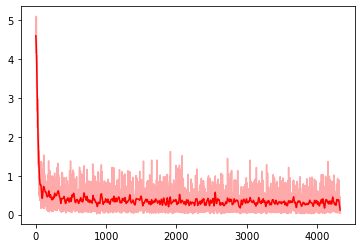

In [14]:
fig, ax = plt.subplots()

y = np.array(losses)
x = np.arange(y.shape[0])
y_smooth = gaussian_filter1d(y, 5, mode="nearest")

ax.plot(x, y, c="#ffaaaa")
ax.plot(x, y_smooth, "r")

plt.show()

In [15]:
# Save model
torch.save(model.state_dict(), "model.softmax.nospace.pt")

In [16]:
# Import model for inference
model = Model()
model.load_state_dict(torch.load("model.softmax.nospace.pt"))
model.eval()

Model(
  (embedding): Embedding(38, 16, padding_idx=0)
  (gru): GRU(16, 32, bidirectional=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

## Apply model

In [17]:
def infer_syllable(pronunciation):
    
    # Encode
    phonemes, split_after, is_vowel = encode(pronunciation)

    # Apply model
    logits = model._encode(phonemes.unsqueeze(1), torch.tensor(phonemes.shape[0]).unsqueeze(0)).squeeze(1)

    # Reconstruct pronunciation
    offsets = torch.arange(is_vowel.shape[0])[is_vowel]
    parts = []
    for o in range(offsets[0]):
        parts.append(IPA[phonemes[o]])
    for i, j in zip(offsets[:-1], offsets[1:]):
        k = i + logits[i:j].argmax()
        for o in range(i, k+1):
            parts.append(IPA[phonemes[o]])
        parts.append(".")
        for o in range(k+1, j):
            parts.append(IPA[phonemes[o]])
    for o in range(offsets[-1], phonemes.shape[0]):
        parts.append(IPA[phonemes[o]])
    syllable = "".join(parts)
    return syllable

In [18]:
# Manual example (from train set)
infer_syllable("vɛk.tœʁ a.le.a.twaʁ kɔ̃.ti.ny")

'vɛk.tœʁ.a.le.a.twaʁ.kɔ̃.ti.ny'

In [19]:
# Apply on some element of the test set
n = len(test_values)
indices = torch.randperm(n)[:10]
for i in indices:
    truth = test_values[i]
    truth = truth.replace(" ", ".").replace("‿", "")
    prediction = infer_syllable(test_values[i])
    status = "OK" if truth == prediction else "NOPE"
    print(f"#{i}: {status}")
    print(f"  truth: {truth}")
    print(f"  pred.: {prediction}")

#4783: OK
  truth: ʁa.pɔʁ.te
  pred.: ʁa.pɔʁ.te
#23778: OK
  truth: pi.tɛn
  pred.: pi.tɛn
#44206: OK
  truth: ɑ̃.bɔʁ.ne
  pred.: ɑ̃.bɔʁ.ne
#399: OK
  truth: ʁə.ka.dɛ.tə.ʁje
  pred.: ʁə.ka.dɛ.tə.ʁje
#30935: OK
  truth: a.ɡaʁd
  pred.: a.ɡaʁd
#60741: OK
  truth: lu.vɛ.tə.ʁjɔ̃
  pred.: lu.vɛ.tə.ʁjɔ̃
#55957: OK
  truth: syʁ.vi.ʁe
  pred.: syʁ.vi.ʁe
#2461: OK
  truth: siz.ʁɛ̃.dɔʁ.nə.man
  pred.: siz.ʁɛ̃.dɔʁ.nə.man
#46834: OK
  truth: o.to.sɑ̃.tʁe
  pred.: o.to.sɑ̃.tʁe
#5296: OK
  truth: myl.ti.mɔ.da.li.zas
  pred.: myl.ti.mɔ.da.li.zas


In [20]:
# Apply on some element of the test set
n = len(test_values)
ok = 0
for i in tqdm(range(n)):
    truth = test_values[i]
    truth = truth.replace(" ", ".").replace("‿", "")
    prediction = infer_syllable(test_values[i])
    if truth == prediction:
        ok += 1
print(f"sentence-level accuracy: {100.0 * ok / n:.2f}%")


sentence-level accuracy: 95.65%


## Evaluate

In [21]:
# TODO ...